In [5]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import itertools
from feature_geometries import *
from sklearn.externals import joblib
import rasterio
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set()
%matplotlib inline

In [6]:
def create_latlon_grid(north, south, east, west):
    step = 0.0005 #close to 100m spacing in lat and long (+/- 10m in Bay Area)
    lat_steps = int((north - south)/step)
    long_steps = int((east - west)/step)
    
    lats = np.linspace(south, north, num=lat_steps)
    longs = np.linspace(east, west, num=long_steps)
    
    LatLong_list = list(itertools.product(longs, lats))
    geometry = [Point(xy) for xy in zip(LatLong_list)] #shapely point
    
    gdf = gpd.GeoDataFrame(LatLong_list, geometry=geometry, columns = ['Long', 'Lat'])
    
    return(gdf)

def find_closest_road(gps, roads, buffer_dist = 0.0003):

    road_index = roads.sindex
    circle = gps.buffer(buffer_dist) #build buffer around point (~ 30 meters)
    
    possible_matches_index = list(road_index.intersection(circle.bounds)) #get index of possible nearest roads
    possible_matches = roads.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(circle)].copy()

    #get distances to roads in buffer
    precise_matches['distance'] = precise_matches['geometry'].distance(gps)
    
    if precise_matches['distance'].empty is False:
        return(precise_matches.sort_values(['distance']).drop_duplicates('distance').iloc[0, 3])
    else:
        return('outside_area')


# Feature Engineering for Heatmap

## Process zoning for entire Bay Area

In [7]:
# Import datasets for feature building
all_zones = gpd.read_file('data/Planned_Land_Use_2006/Planned_Land_Use_2006.shp')
census_tracts = import_gpd('data/census_tracts.csv')

In [8]:
all_zones.gengplu.unique()

array(['Residential', 'Mixed Use: Commercial & Industrial',
       'Agriculture/Resource Extraction', 'Commercial',
       'Parks/Open Space', 'Education/Public/Semi-Public', 'Water',
       'Mixed Use: Residential & Parks/Open Space or Agriculture/Resource Extraction',
       'Mixed Use: Other', 'Other/Unknown',
       'Mixed Use: Residential & Commercial', 'Industrial',
       'Mixed Use: Agriculture/Resource Extraction & Parks/Open Space',
       'Mixed Use', 'Mixed Use: Residential & Industrial'], dtype=object)

In [9]:
## zoning designations to be generalized across the Bay Area
residential = ['Residential', 'Mixed Use: Residential & Parks/Open Space or Agriculture/Resource Extraction']
open_space = ['Parks/Open Space', 'Agriculture/Resource Extraction', 'Water']
commercial = ['Commercial']
industrial = ['Industrial']

all_zones['zone'] = np.where(all_zones['gengplu'].str.contains('Mixed'), 'mixed', all_zones['gengplu'])

## simply down to the above zoning designations
all_zones['zone'] = all_zones['zone'].replace(dict.fromkeys(residential, 'residential'))
all_zones['zone'] = all_zones['zone'].replace(dict.fromkeys(commercial, 'commercial'))
all_zones['zone'] = all_zones['zone'].replace(dict.fromkeys(open_space, 'open_space'))
all_zones['zone'] = all_zones['zone'].replace(dict.fromkeys(industrial, 'industrial'))

In [10]:
east_zones = all_zones[all_zones.county.isin(['Alameda','Contra Costa'])]

In [11]:
# Save to csv
east_zones.to_csv('east_zones.csv')

## Get road network for region of interest

In [108]:
# grab street data (roads and intersections) for East Bay
places = ['El Cerrito, California, USA',
          'Albany, California, USA',
          'Piedmont, California, USA', 
          'Berkeley, California, USA',
          'Emeryville, California, USA',
          'Oakland, California, USA']

eastbay_rds = ox.graph_from_place(places, network_type = 'drive')

In [91]:
# grab street data (roads and intersections) for entire city
nodes, edges = ox.graph_to_gdfs(eastbay_rds)
all_roads = edges
all_intersections = nodes

#all_intersections.to_csv('all_intersections.csv')
#all_roads.to_csv('all_roads.csv')

In [99]:
edges.head()

,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v
0,NaN,"LINESTRING (-122.3552127 37.931505, -122.35521...",residential,NaN,0,NaN,107.281,NaN,15th Street,False,7857548,NaN,NaN,57823233,57823235
1,NaN,"LINESTRING (-122.3811283 37.9225004, -122.3811...",residential,NaN,0,NaN,46.437,NaN,Alvarado Street,False,7879231,NaN,NaN,57950210,57869260
2,NaN,"LINESTRING (-122.3552142 37.9324698, -122.3552...",residential,NaN,0,NaN,178.625,NaN,15th Street,False,7857548,NaN,NaN,57823235,57823236
3,NaN,"LINESTRING (-122.3552142 37.9324698, -122.3552...",residential,NaN,0,NaN,107.281,NaN,15th Street,False,7857548,NaN,NaN,57823235,57823233
4,NaN,"LINESTRING (-122.3552142 37.9324698, -122.3542...",residential,NaN,0,NaN,83.362,NaN,Chanslor Avenue,False,7865077,NaN,NaN,57823235,57873993


## Regional polygon

In [93]:
eastbay_cities = ox.gdf_from_places(places)

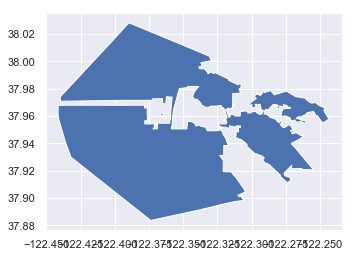

In [94]:
eastbay_cities.plot()

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


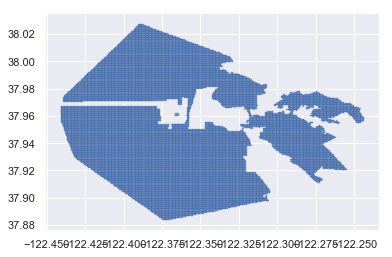

In [95]:
all_grid = create_latlon_grid(np.max(eastbay_cities.bbox_north), np.min(eastbay_cities.bbox_south), 
                   np.max(eastbay_cities.bbox_east), np.min(eastbay_cities.bbox_west))

#all_points = all_grid
# #try a spatial join
all_points = gpd.sjoin(all_grid, eastbay_cities, how="inner", op="intersects")
plt.scatter(all_points.Long, all_points.Lat, s=0.1);

In [96]:
# create geometery for points
geometry = [Point(xy) for xy in zip(all_points.Long, all_points.Lat)]
all_points = gpd.GeoDataFrame(all_points, geometry=geometry, crs={'init' :'epsg:4326'}) #Mercator lat long input


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

# Feature Engineering

In [20]:
# grab subsets of roadtypes
highways = all_roads[all_roads.highway == 'motorway']
primary = all_roads[all_roads.highway == 'primary']
secondary = all_roads[all_roads.highway == 'secondary']
resid = all_roads[all_roads.highway == 'residential']
all_roads.crs

{'init': 'epsg:4326'}

## Road Types

In [97]:
#calculate road_type for each point ...
all_points['road_type'] = all_points['geometry'].apply(find_closest_road, roads = all_roads, buffer_dist = 0.001)

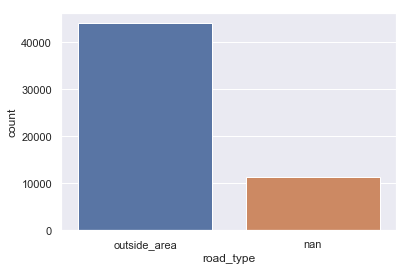

In [98]:
# check values
sns.countplot(all_points.road_type.astype(str))

In [51]:
# Cleaning road categories ...
all_points['road_type'] = all_points['road_type'].str.replace('_link', '')
all_points['road_type'] = np.where(all_points['road_type'] == 'trunk', 'secondary', all_points['road_type'])
all_points['road_type'] = np.where(all_points['road_type'] == 'living_street', 'residential', all_points['road_type'])
all_points['road_type'] = np.where(all_points['road_type'] == 'a', 'unclassified', all_points['road_type'])

# Drop all point not measured on a OpenStreetMap roadway
all_points = all_points[all_points.road_type != 'outside_area']

In [52]:
all_points['road_type'].unique()

array(['residential', 'secondary', 'tertiary', 'unclassified', 'motorway',
       'primary', nan], dtype=object)

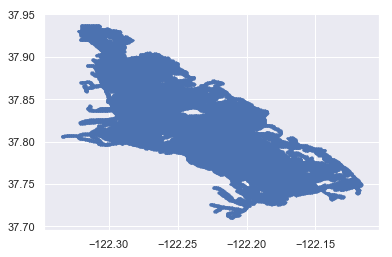

In [53]:
#all_roads.plot()
plt.scatter(all_points.Long, all_points.Lat, s=1)
all_points.crs = {'init' :'epsg:4326'}

## Distances to roadways and signals

In [54]:
## Calculate distance to nearest major roadway

# much faster to do the re-projection to meters outside of the apply function
eastbay_utm = all_points.to_crs({'init': 'epsg:32610'}).copy()
highway_utm = highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = secondary.to_crs({'init': 'epsg:32610'}).copy()

all_points['closest_highway'] = eastbay_utm['geometry'].apply(distance_to_roadway, roadway = highway_utm)
all_points['closest_primary'] = eastbay_utm['geometry'].apply(distance_to_roadway, roadway = primary_utm)
all_points['closest_secondary'] = eastbay_utm['geometry'].apply(distance_to_roadway, roadway = secondary_utm)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [55]:
## Calculate distance to nearest intersection and traffic signals
nodes_utm = all_intersections.to_crs({'init': 'epsg:32610'}).copy() #re-project as above
signals = nodes_utm[nodes_utm['highway'] == 'traffic_signals'].copy()

all_points['corner_dist'] = eastbay_utm['geometry'].apply(nearest_intersection,
                                                            intersections = nodes_utm['geometry'])

all_points['signal_dist'] = eastbay_utm['geometry'].apply(nearest_intersection, 
                                                               intersections = signals['geometry'])

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Merge on census and zoning data

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


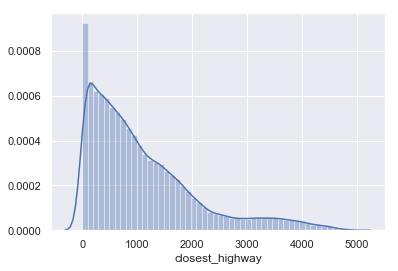

In [59]:
sns.distplot(all_points.closest_highway)

In [60]:
# left merge with the zoning data
all_points = all_points.drop(['index_right'], axis = 1)
all_points = gpd.sjoin(all_points, east_zones, how='left', op='intersects')

#left merge with the census data
all_points = all_points.drop(['index_right'], axis = 1)
all_points = gpd.sjoin(all_points, census_tracts, how='left', op='intersects')
all_points = all_points.drop('index_right', axis=1)
all_points.shape

(66225, 34)

In [61]:
all_points.columns

Index(['Long', 'Lat', 'geometry', 'bbox_east', 'bbox_north', 'bbox_south',
       'bbox_west', 'place_name', 'road_type', 'closest_highway',
       'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
       'objectid', 'juris', 'county_left', 'lpscode', 'plandate', 'origgplu',
       'gengplu', 'acres', 'Shape__Are', 'Shape__Len', 'zone', 'population',
       'pop_var', 'tract_name', 'GEOID', 'state', 'county_right', 'tract',
       'area', 'pop_den'],
      dtype='object')

## Distance to nearest industrial zone

In [62]:
## Calculate distance to industrial zone
#re-projections
zones_utm = east_zones.to_crs({'init': 'epsg:32610'}).copy()
eastbay_utm = all_points.to_crs({'init': 'epsg:32610'}).copy()
industry = zones_utm[zones_utm.zone == 'industrial']

#calculations
all_points['industry_dist'] = eastbay_utm['geometry'].apply(distance_to_zoning, zone = industry)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


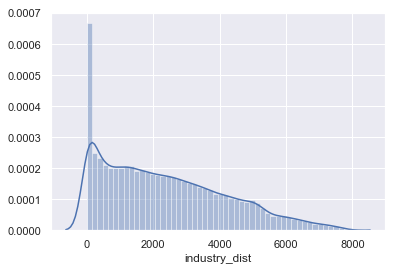

In [63]:
sns.distplot(all_points['industry_dist']);

## Weather data

In [64]:
#all_points = pd.read_csv('heatmap.csv')

In [65]:
#all_points = all_points.iloc[:, :-4]

In [66]:
# Wind
lons = np.array(all_points['Long'].values)
lats = np.array(all_points['Lat'].values)
winds = np.zeros(all_points.shape[0])

with rasterio.open('data/wc2.0_30s_wind/avg_wind.tif') as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        winds[i] = val

# remove below zero values
winds = np.where(winds < 0, np.nan, winds)

all_points['wind'] = winds

In [67]:
# Mean annual temperature
temp = np.zeros(all_points.shape[0])

with rasterio.open('data/wc2.0_30s_tavg/avg_ta.tif') as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        temp[i] = val

# remove below zero values
temp = np.where(temp < 0, np.nan, temp)

all_points['temp'] = temp

In [73]:
all_points.columns

Index(['Long', 'Lat', 'geometry', 'bbox_east', 'bbox_north', 'bbox_south',
       'bbox_west', 'place_name', 'road_type', 'closest_highway',
       'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
       'objectid', 'juris', 'county_left', 'lpscode', 'plandate', 'origgplu',
       'gengplu', 'acres', 'Shape__Are', 'Shape__Len', 'zone', 'population',
       'pop_var', 'tract_name', 'GEOID', 'state', 'county_right', 'tract',
       'area', 'pop_den', 'industry_dist', 'wind', 'temp'],
      dtype='object')

In [69]:
all_points = all_points.dropna()
all_points.to_csv('eastbay_grid.csv')

# Model the heatmap

In [4]:
all_points = pd.read_csv('eastbay_grid.csv')
all_points.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Long', 'Lat', 'geometry', 'bbox_east',
       'bbox_north', 'bbox_south', 'bbox_west', 'road_type', 'closest_highway',
       'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
       'objectid', 'juris', 'county_left', 'lpscode', 'plandate', 'origgplu',
       'gengplu', 'acres', 'Shape__Are', 'Shape__Len', 'zone', 'population',
       'pop_var', 'tract_name', 'GEOID', 'state', 'county_right', 'tract',
       'area', 'pop_den', 'industry_dist', 'wind', 'temp'],
      dtype='object')

In [74]:
# Grab relevant features
X_vars = ['road_type', 'closest_highway', 'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
         'zone', 'pop_den', 'industry_dist', 'wind', 'temp']

X = all_points[X_vars].copy()

In [75]:
# Re-create dummy variable columns for input
# for road type....
X['road_type_motorway'] = np.where(X.road_type == 'motorway', 1, 0)
X['road_type_primary'] = np.where(X.road_type == 'primary', 1, 0)
X['road_type_residential'] = np.where(X.road_type == 'residential', 1, 0)
X['road_type_secondary'] = np.where(X.road_type == 'secondary', 1, 0)
X['road_type_tertiary'] = np.where(X.road_type == 'tertiary', 1, 0)
X['road_type_unclassified'] = np.where(X.road_type == 'unclassified', 1, 0)

# for zoning...
X['zone_commercial'] = np.where(X.road_type == 'commercial', 1, 0)
X['zone_industrial'] = np.where(X.road_type == 'industrial', 1, 0)
X['zone_mixed'] = np.where(X.road_type == 'mixed', 1, 0)
X['zone_open_space'] = np.where(X.road_type == 'open_space', 1, 0)
X['zone_residential'] = np.where(X.road_type == 'residential', 1, 0)

#drop extra columns following dummy variables
X = X.drop(['zone', 'road_type'], axis = 1)

In [76]:
print(X.columns)
print(all_points.shape)

Index(['closest_highway', 'closest_primary', 'closest_secondary',
       'corner_dist', 'signal_dist', 'pop_den', 'industry_dist', 'wind',
       'temp', 'road_type_motorway', 'road_type_primary',
       'road_type_residential', 'road_type_secondary', 'road_type_tertiary',
       'road_type_unclassified', 'zone_commercial', 'zone_industrial',
       'zone_mixed', 'zone_open_space', 'zone_residential'],
      dtype='object')
(61389, 37)


In [85]:
no2_model = joblib.load("./models/xgb_no2.pkl")
bc_model = joblib.load("./models/xgb_bc.pkl")

In [86]:
all_points['no2'] = no2_model.predict(X)
all_points['bc'] = bc_model.predict(X)

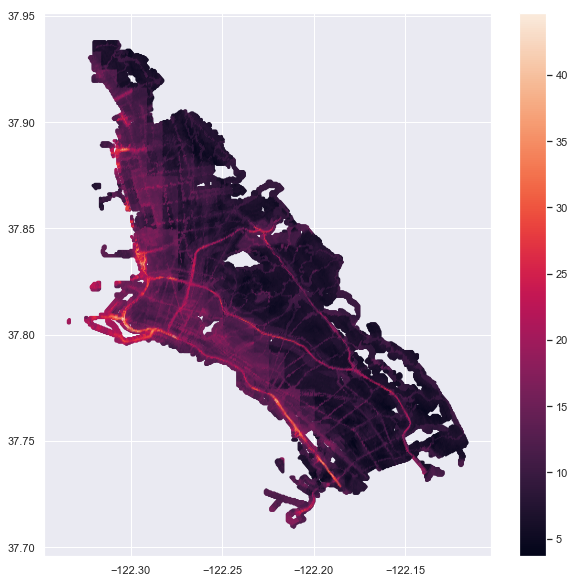

In [88]:
plt.figure(figsize = (10, 10))
plt.scatter(all_points.Long, all_points.Lat, s=5, c = all_points.no2)
plt.colorbar();

In [89]:
all_points.to_csv('heatmap.csv')